# Solving cartpole task with policy-based RL algorithms

**Decription of the task:**
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import gym

# Vanilla Policy-Gradient 

In [31]:
import PolicyGradient

In [32]:
from importlib import reload
reload(PolicyGradient)

<module 'PolicyGradient' from '/home/nicola/Nicola_unipd/MasterThesis/Policy-based-RL/PolicyGradient.py'>

In [78]:
def play_episode(agent, env, return_states=False):
    # Reset environment (start of an episode)
    state = env.reset()
    rewards = []
    log_probs = []
    done = []
    
    if return_states:
        states = [state]
        
        
    steps = 0
    while True:
        action, log_prob = agent.get_action(state, return_log = True)
        new_state, reward, terminal, info = env.step(action) # gym standard step's output
        
        if return_states:
            states.append(new_state)
            
        if terminal and 'TimeLimit.truncated' not in info:
            # give -1 if cartpole falls but not if episode is truncated
            reward = -1 
            
        rewards.append(reward)
        log_probs.append(log_prob)
        done.append(terminal)
        
        if terminal:
            break
            
        state = new_state
       
    rewards = np.array(rewards)
    done = np.array(done)
    
    if return_states:
        return rewards, log_probs, np.array(states), done
    else:
        return rewards, log_probs, done

In [34]:
def train_cartpole(n_episodes = 100, lr = 0.01, gamma = 0.99):
    # Create environment
    env = gym.make("CartPole-v1")
    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n
    # Init agent
    agent = PolicyGradient.PolicyGrad(observation_space, action_space, lr, gamma)
    performance = []
    losses = []
    for e in range(n_episodes):
        rewards, log_probs, _ = play_episode(agent, env)
        performance.append(np.sum(rewards))
        if (e+1)%10 == 0:
            print("Episode %d - reward: %.0f"%(e+1, np.mean(performance[-10:])))
        
        loss = agent.update(rewards, log_probs)
        losses.append(loss)
    return agent, np.array(performance), np.array(losses)

In [35]:
%%time
trained_agentPG, cumulative_rewardPG, lossesPG = train_cartpole(n_episodes = 500, lr=5e-3)

Episode 10 - reward: 36
Episode 20 - reward: 18
Episode 30 - reward: 25
Episode 40 - reward: 50
Episode 50 - reward: 51
Episode 60 - reward: 68
Episode 70 - reward: 103
Episode 80 - reward: 162
Episode 90 - reward: 281
Episode 100 - reward: 126
Episode 110 - reward: 156
Episode 120 - reward: 331
Episode 130 - reward: 466
Episode 140 - reward: 424
Episode 150 - reward: 162
Episode 160 - reward: 119
Episode 170 - reward: 61
Episode 180 - reward: 117
Episode 190 - reward: 96
Episode 200 - reward: 94
Episode 210 - reward: 234
Episode 220 - reward: 393
Episode 230 - reward: 340
Episode 240 - reward: 500
Episode 250 - reward: 500
Episode 260 - reward: 500
Episode 270 - reward: 472
Episode 280 - reward: 354
Episode 290 - reward: 282
Episode 300 - reward: 356
Episode 310 - reward: 168
Episode 320 - reward: 280
Episode 330 - reward: 500
Episode 340 - reward: 490
Episode 350 - reward: 496
Episode 360 - reward: 451
Episode 370 - reward: 461
Episode 380 - reward: 420
Episode 390 - reward: 500
Epis

In [36]:
T = False
if T:
    n_runs = 30
    results_v0 = []
    for i in range(n_runs):
        trained_agentPG, cumulative_rewardPG, lossesPG = train_cartpole(n_episodes = 500, lr=5e-3)
        results_v0.append(cumulative_rewardPG)

In [37]:
if T:
    np.save('Results/REINFORCE_perf', results_v0)

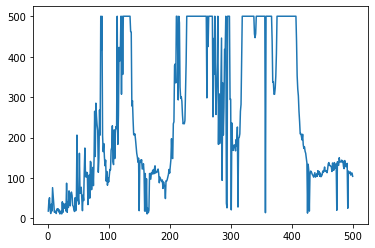

In [38]:
episodes = np.arange(1,len(cumulative_rewardPG)+1)
plt.plot(episodes, cumulative_rewardPG)
plt.show()

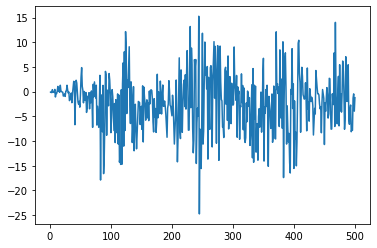

In [39]:
plt.plot(episodes, lossesPG)
plt.show()

In [40]:
def render_test_episode(agent):
    # Create environment
    env = gym.make("CartPole-v1")
    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n
    state = env.reset()
    while True:
        env.render()
        action = agent.get_action(state, return_log = False)
        new_state, reward, terminal, info = env.step(action) # gym standard step's output
        if terminal: 
            break
        else: 
            state = new_state
    env.close()

In [41]:
render_test_episode(trained_agentPG) 

# Advantage Actor-Critic - trajectory version

In [42]:
import ActorCritic

In [55]:
from importlib import reload
reload(ActorCritic)

<module 'ActorCritic' from '/home/nicola/Nicola_unipd/MasterThesis/Policy-based-RL/ActorCritic.py'>

In [56]:
class experience_buffer():
    def __init__(self, r_list, logp_list, s_list, done_list):
        self.r_list = r_list
        self.logp_list = logp_list
        self.s_list = s_list
        self.done_list = done_list
    
    def get_exp(self):
        L = np.min([len(r) for r in self.r_list])
        r_list_final = np.array([x[-L:] for x in self.r_list])
        logp_list_final = [x[-L:] for x in self.logp_list]
        s_list_final = np.array([x[-L-1:] for x in self.s_list])
        done_list_final = np.array([x[-L:] for x in self.done_list])
        return r_list_final, logp_list_final, s_list_final, done_list_final

In [79]:
def train_cartpole_A2C(n_epochs = 100, n_batches = 1, lr = 0.01, gamma = 0.99, TD=True):
    # Create environment
    env = gym.make("CartPole-v1")
    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n
    # Init agent
    agent = ActorCritic.A2C(observation_space, action_space, lr, gamma, TD=TD, discrete=False)
    performance = []
    for e in range(n_epochs):
        r_list = []
        logp_list = []
        s_list = []
        done_list = []
        score = []
        
        for b in range(n_batches):
            rewards, log_probs, states, done = play_episode(agent, env, return_states=True)
            r_list.append(rewards)
            logp_list.append(log_probs)
            s_list.append(states)
            done_list.append(done)
            score.append(np.sum(rewards))
            
        performance.append(np.mean(score))
        if (e+1)%10 == 0:
            print("Episode %d - reward: %.0f"%(e+1, np.mean(performance[-10:])))
        exp_buff = experience_buffer(r_list, logp_list, s_list, done_list)
        rewards, log_probs, states, done = exp_buff.get_exp()
        #print("rewards.shape ", rewards.shape)
        #print("log_probs ", log_probs)
        #print("states.shape ", states.shape)
        #print("done.shape ", done.shape)
        #print("done ", done)
        agent.update(rewards, log_probs[0], states, done)
        
    return agent, np.array(performance)

In [80]:
%%time
agent_TD, performance_TD = train_cartpole_A2C(n_epochs=1500, lr=5e-3)

Episode 10 - reward: 16
Episode 20 - reward: 14
Episode 30 - reward: 8
Episode 40 - reward: 8
Episode 50 - reward: 7
Episode 60 - reward: 8
Episode 70 - reward: 12
Episode 80 - reward: 29
Episode 90 - reward: 21
Episode 100 - reward: 16
Episode 110 - reward: 19
Episode 120 - reward: 24
Episode 130 - reward: 18
Episode 140 - reward: 21
Episode 150 - reward: 12
Episode 160 - reward: 20
Episode 170 - reward: 17
Episode 180 - reward: 20
Episode 190 - reward: 26
Episode 200 - reward: 39
Episode 210 - reward: 40
Episode 220 - reward: 57
Episode 230 - reward: 74
Episode 240 - reward: 126
Episode 250 - reward: 96
Episode 260 - reward: 109
Episode 270 - reward: 150
Episode 280 - reward: 116
Episode 290 - reward: 75
Episode 300 - reward: 84
Episode 310 - reward: 66
Episode 320 - reward: 62
Episode 330 - reward: 58
Episode 340 - reward: 60
Episode 350 - reward: 78
Episode 360 - reward: 77
Episode 370 - reward: 76
Episode 380 - reward: 55
Episode 390 - reward: 81
Episode 400 - reward: 66
Episode 4

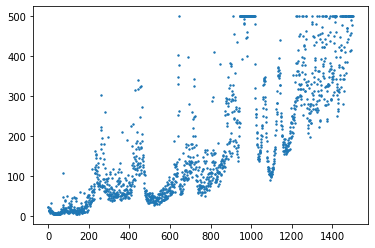

In [81]:
episodes = np.arange(1,len(performance_TD)+1)
plt.scatter(episodes, performance_TD, s=2)

In [83]:
render_test_episode(agent_TD) 

In [84]:
%%time
agent_MC, performance_MC = train_cartpole_A2C(n_epochs=1500, lr=5e-3, TD=False)

Episode 10 - reward: 32
Episode 20 - reward: 36
Episode 30 - reward: 29
Episode 40 - reward: 51
Episode 50 - reward: 80
Episode 60 - reward: 72
Episode 70 - reward: 123
Episode 80 - reward: 227
Episode 90 - reward: 23
Episode 100 - reward: 8
Episode 110 - reward: 11
Episode 120 - reward: 10
Episode 130 - reward: 8
Episode 140 - reward: 10
Episode 150 - reward: 11
Episode 160 - reward: 11
Episode 170 - reward: 10
Episode 180 - reward: 10
Episode 190 - reward: 10
Episode 200 - reward: 12
Episode 210 - reward: 12
Episode 220 - reward: 13
Episode 230 - reward: 12
Episode 240 - reward: 11
Episode 250 - reward: 15
Episode 260 - reward: 13
Episode 270 - reward: 15
Episode 280 - reward: 16
Episode 290 - reward: 21
Episode 300 - reward: 27
Episode 310 - reward: 58
Episode 320 - reward: 119
Episode 330 - reward: 384
Episode 340 - reward: 190
Episode 350 - reward: 18
Episode 360 - reward: 18
Episode 370 - reward: 21
Episode 380 - reward: 33
Episode 390 - reward: 28
Episode 400 - reward: 26
Episod

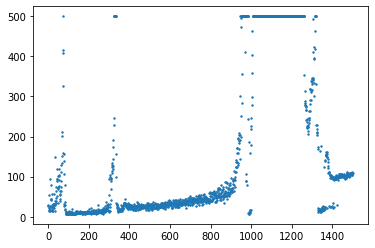

In [85]:
episodes = np.arange(1,len(performance_MC)+1)
plt.scatter(episodes, performance_MC, s=2)

In [86]:
render_test_episode(agent_MC) 

## Reward shaping

Try to make a more informative reward.
Idea: store the whole trajectory, then subtract $-\frac{eps \cdot t}{T}$ to all rewards, where $t$ is the step at which the reward was obtained and $T$ the total number of steps.

In [103]:
def shape_rewards(r, eps, power=1):
    T = len(r)
    t = np.arange(1,T+1)
    r -= eps*(t/T)**power
    return r

In [106]:
def train_cartpole_A2C_shaped(n_epochs = 100, n_batches = 1, lr = 0.01, gamma = 0.99, TD=True, eps=1, power=1):
    # Create environment
    env = gym.make("CartPole-v1")
    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n
    # Init agent
    agent = ActorCritic.A2C(observation_space, action_space, lr, gamma, TD=TD, discrete=False)
    performance = []
    for e in range(n_epochs):
        r_list = []
        logp_list = []
        s_list = []
        done_list = []
        score = []
        
        for b in range(n_batches):
            rewards, log_probs, states, done = play_episode(agent, env, return_states=True)
            if done[-1] == True and len(done) != 500:
                rewards = shape_rewards(rewards, eps, power)
            r_list.append(rewards)
            logp_list.append(log_probs)
            s_list.append(states)
            done_list.append(done)
            score.append(np.sum(rewards))
            
        performance.append(np.mean(score))
        if (e+1)%10 == 0:
            print("Episode %d - reward: %.0f"%(e+1, np.mean(performance[-10:])))
        exp_buff = experience_buffer(r_list, logp_list, s_list, done_list)
        rewards, log_probs, states, done = exp_buff.get_exp()
        #print("rewards.shape ", rewards.shape)
        #print("log_probs ", log_probs)
        #print("states.shape ", states.shape)
        #print("done.shape ", done.shape)
        #print("done ", done)
        agent.update(rewards, log_probs[0], states, done)
        
    return agent, np.array(performance)

In [100]:
%%time
agent_TD_sh, performance_TD_sh = train_cartpole_A2C_shaped(n_epochs=1500, lr=5e-3, power=2, eps=0.01)

Episode 10 - reward: 20
Episode 20 - reward: 11
Episode 30 - reward: 7
Episode 40 - reward: 8
Episode 50 - reward: 7
Episode 60 - reward: 7
Episode 70 - reward: 7
Episode 80 - reward: 7
Episode 90 - reward: 7
Episode 100 - reward: 7
Episode 110 - reward: 8
Episode 120 - reward: 8
Episode 130 - reward: 7
Episode 140 - reward: 7
Episode 150 - reward: 7
Episode 160 - reward: 7
Episode 170 - reward: 7
Episode 180 - reward: 8
Episode 190 - reward: 8
Episode 200 - reward: 17
Episode 210 - reward: 15
Episode 220 - reward: 21
Episode 230 - reward: 26
Episode 240 - reward: 14
Episode 250 - reward: 27
Episode 260 - reward: 28
Episode 270 - reward: 28
Episode 280 - reward: 33
Episode 290 - reward: 49
Episode 300 - reward: 59
Episode 310 - reward: 63
Episode 320 - reward: 112
Episode 330 - reward: 154
Episode 340 - reward: 145
Episode 350 - reward: 219
Episode 360 - reward: 216
Episode 370 - reward: 106
Episode 380 - reward: 109
Episode 390 - reward: 321
Episode 400 - reward: 232
Episode 410 - rew

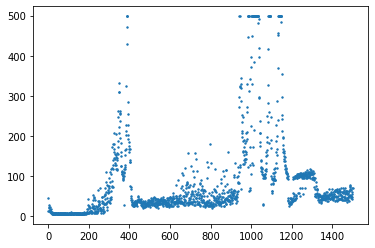

In [101]:
episodes = np.arange(1,len(performance_TD_sh)+1)
plt.scatter(episodes, performance_TD_sh, s=2)

In [102]:
render_test_episode(agent_TD_sh) 

In [111]:
%%time
agent_MC_sh, performance_MC_sh = train_cartpole_A2C_shaped(n_epochs=1500, lr=5e-3, power=2, eps=0.1)

Episode 10 - reward: 19
Episode 20 - reward: 21
Episode 30 - reward: 13
Episode 40 - reward: 9
Episode 50 - reward: 8
Episode 60 - reward: 9
Episode 70 - reward: 13
Episode 80 - reward: 15
Episode 90 - reward: 21
Episode 100 - reward: 12
Episode 110 - reward: 11
Episode 120 - reward: 14
Episode 130 - reward: 24
Episode 140 - reward: 14
Episode 150 - reward: 22
Episode 160 - reward: 19
Episode 170 - reward: 14
Episode 180 - reward: 13
Episode 190 - reward: 16
Episode 200 - reward: 22
Episode 210 - reward: 25
Episode 220 - reward: 23
Episode 230 - reward: 22
Episode 240 - reward: 27
Episode 250 - reward: 28
Episode 260 - reward: 40
Episode 270 - reward: 42
Episode 280 - reward: 82
Episode 290 - reward: 168
Episode 300 - reward: 199
Episode 310 - reward: 76
Episode 320 - reward: 106
Episode 330 - reward: 133
Episode 340 - reward: 130
Episode 350 - reward: 140
Episode 360 - reward: 145
Episode 370 - reward: 136
Episode 380 - reward: 110
Episode 390 - reward: 104
Episode 400 - reward: 113
E

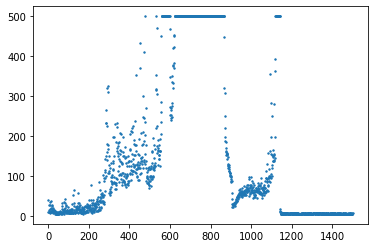

In [112]:
episodes = np.arange(1,len(performance_MC_sh)+1)
plt.scatter(episodes, performance_MC_sh, s=2)

In [113]:
render_test_episode(agent_MC_sh) 

**Final discussion:** It is undisputable that A2C setup is much better than a random policy, so it defenitely learns something correctly. I found it very unstable w.r.t. the learning rate and I suspect that a better tuning would require to differentiate between the one of the critic and the one of the actor.

Since each training procedure is stochastic, every time the result is different, all other things been equal, so what I'm going to say next is not supported strongly by the data, but can verified if one has time using an ensemble of agents and averaging the performances at each epoch.

What I observed is that:
- the TD agent is more unstable than the MC one;
- shaping the reward function changes a lot the results. I've done this in 2 ways: the first one is to give -1 instead of +1 to the last reward of an episode if the episode ends with the cartpole falling. This enables the agent to differentiate between an episode ended by truncation (good, it scored the maximum possible) or one in which it committed a sequence of non-optimal actions (bad, could have done better). The second one is similar but more sophisticated and is based on the idea of smoothing the reward, so that the responsability for failing the task gets shared in a weighted way by the last actions taken (with polynomial decay, whose power is a parameter of the model). I found that with these 2 changes the A2C with Monte Carlo estimation reached the maximum reward possible and was much more stable on that performance than all other configurations.

Anyway there is always a source of instability causing sudden drops in performance during the training.